<a href="https://colab.research.google.com/github/Anjan-AI/TSAI-EVA5/blob/master/Session%2010%20-%20Advanced%20Concepts%20in%20Training%20%26%20Learning%20Rates/EVA5_Session_10_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Added the modular files to the drive and added to path

In [1]:
%rm -rf TSAI-EVA5/

In [2]:

!git clone https://github.com/Anjan-AI/TSAI-EVA5.git

Cloning into 'TSAI-EVA5'...
remote: Enumerating objects: 384, done.
remote: Counting objects: 100% (384/384), done.
remote: Compressing objects: 100% (312/312), done.
remote: Total 579 (delta 159), reused 252 (delta 66), pack-reused 195
Receiving objects: 100% (579/579), 28.24 MiB | 15.15 MiB/s, done.
Resolving deltas: 100% (232/232), done.


In [3]:
import sys
sys.path.append('/content/TSAI-EVA5/Session 10 - Advanced Concepts in Training & Learning Rates/')
#sys.path.append('/content/TSAI-EVA5/Session 9 - DATA AUGMENTATION')

### Import all the Library

In [4]:
import torch
import os
import torchvision
import torchvision.transforms as transfroms
from Dataset.dataset import Dataset,cifar10_classes
from Dataset.image_augmentations import AlbumentationTransforms
from Utils.SetCuda import set_seed,initialize_cuda
from Utils.utilities import print_model_summary,cross_entropy_loss
from Utils.evaluate import show_misclassified_images,evaluate_classwise_accuracy
from Utils.GradCam import GradCamView
from Utils.show_image import imshow ,show_train_data
from models.resnet import ResNet18
from Training.Training_Testing import train ,test,runmodel

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from Utils.lr_finder import LRFinder

In [5]:
classes = cifar10_classes()
#define the transformation 
train_transform = AlbumentationTransforms(augmentation = True, mean=(0.4914, 0.4822, 0.4465) ,std_dev =(0.2471, 0.2435, 0.2616),horizontal_flip_prob=0.6,vertical_flip_prob=0.6,rotate_degree =30.0,cutout= True)
test_transform = AlbumentationTransforms(augmentation = True, mean=(0.4914, 0.4822, 0.4465) ,std_dev =(0.2471, 0.2435, 0.2616))
# allocate the transfroamtions to the the Data class
Data = Dataset(train_transform, test_transform)
# downlaod the data
train_set = Data.download_cifar10dataset(train = True)
test_set = Data.download_cifar10dataset(train = False)

#check for the GUP avaliblbity and manual seeding
seed =1
cuda,device = initialize_cuda(seed)

Files already downloaded and verified
Files already downloaded and verified
GPU Available? True


In [6]:
# Load the test and train data , set the batch size & Num_workeres.
train_loader = Data.data_loader(train_set,cuda= cuda ,batch_size = 64 , num_workers = 4 )
test_loader = Data.data_loader(test_set,cuda= cuda ,batch_size = 64 , num_workers = 4 )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

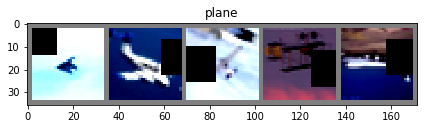

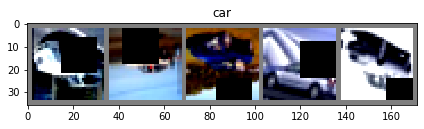

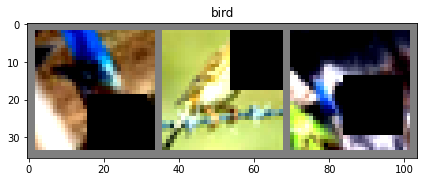

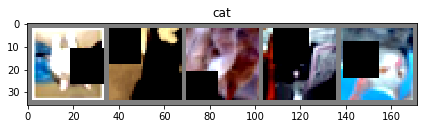

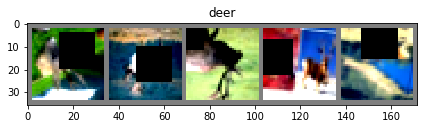

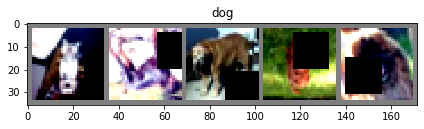

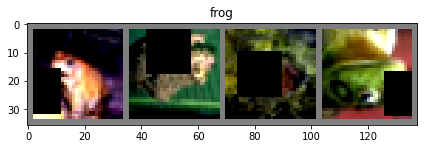

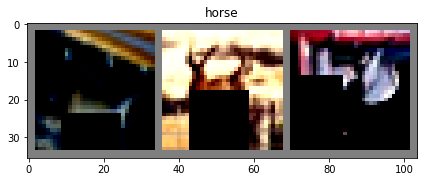

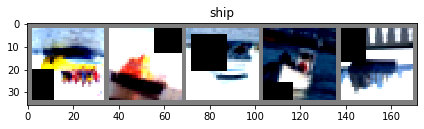

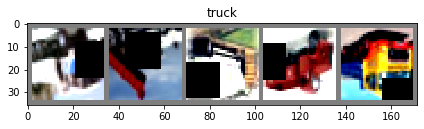

In [8]:
show_train_data(train_loader, classes)

In [9]:
# laod the model and print teh summary
model = ResNet18()
print_model_summary(model, input_size = (3,32,32),device =device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

## Best Learning Rate Finder 

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.22E-03


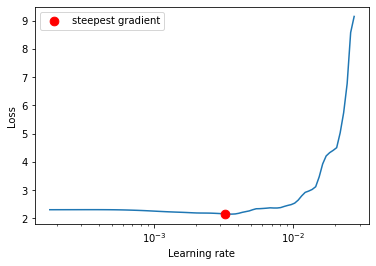

(<matplotlib.axes._subplots.AxesSubplot at 0x7fd211514550>,
 0.003217641750250736)

In [10]:
criterion = cross_entropy_loss() 
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9,weight_decay = 0.0001)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=10, num_iter=200 ,step_mode="exp")
lr_finder.plot()

In [11]:
Best_lr = lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.best_loss)]
Best_lr

0.003612342699709432

In [12]:
lr_finder.reset()

## ReduceLROnPlateau implentation

In [13]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

EPOCHS = 50 # set the no of epcohs

criterion = cross_entropy_loss()  # Create loss function
optimizer = optim.SGD(model.parameters(), lr=Best_lr, momentum=0.9) #define optimzer
#scheduler = StepLR(optimizer, step_size=40, gamma=0.1) # define scheduler
scheduler = ReduceLROnPlateau(optimizer, patience = 5 ,min_lr=1e-4)
train_losses = []
test_losses = []
train_acc = []
test_acc = []
print(device)
model = model.to(device)
runmodel(model,device,train_loader,test_loader,optimizer,scheduler,EPOCHS,criterion, train_losses,train_acc,test_losses,test_acc)

  0%|          | 0/782 [00:00<?, ?it/s]

cuda
EPOCH: 0


Loss=1.541147232055664 Batch_id=781 Accuracy=39.54: 100%|██████████| 782/782 [01:06<00:00, 11.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 4541/10000 (45.41%)

EPOCH: 1


Loss=0.8368404507637024 Batch_id=781 Accuracy=52.27: 100%|██████████| 782/782 [01:06<00:00, 11.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 5889/10000 (58.89%)

EPOCH: 2


Loss=0.948805570602417 Batch_id=781 Accuracy=58.50: 100%|██████████| 782/782 [01:05<00:00, 11.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Accuracy: 6428/10000 (64.28%)

EPOCH: 3


Loss=1.1574937105178833 Batch_id=781 Accuracy=62.72: 100%|██████████| 782/782 [01:06<00:00, 11.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0154, Accuracy: 6619/10000 (66.19%)

EPOCH: 4


Loss=0.6430128812789917 Batch_id=781 Accuracy=66.40: 100%|██████████| 782/782 [01:06<00:00, 11.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0144, Accuracy: 6827/10000 (68.27%)

EPOCH: 5


Loss=1.180159330368042 Batch_id=781 Accuracy=68.45: 100%|██████████| 782/782 [01:06<00:00, 11.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0126, Accuracy: 7181/10000 (71.81%)

EPOCH: 6


Loss=0.8630862832069397 Batch_id=781 Accuracy=70.31: 100%|██████████| 782/782 [01:06<00:00, 11.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0115, Accuracy: 7464/10000 (74.64%)

EPOCH: 7


Loss=0.8667175769805908 Batch_id=781 Accuracy=71.69: 100%|██████████| 782/782 [01:06<00:00, 11.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0111, Accuracy: 7479/10000 (74.79%)

EPOCH: 8


Loss=0.9967016577720642 Batch_id=781 Accuracy=73.10: 100%|██████████| 782/782 [01:06<00:00, 11.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0107, Accuracy: 7673/10000 (76.73%)

EPOCH: 9


Loss=1.032257080078125 Batch_id=781 Accuracy=74.30: 100%|██████████| 782/782 [01:06<00:00, 11.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0108, Accuracy: 7669/10000 (76.69%)

EPOCH: 10


Loss=1.1627267599105835 Batch_id=781 Accuracy=75.59: 100%|██████████| 782/782 [01:06<00:00, 11.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0102, Accuracy: 7750/10000 (77.50%)

EPOCH: 11


Loss=0.8252170085906982 Batch_id=781 Accuracy=76.23: 100%|██████████| 782/782 [01:06<00:00, 11.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0098, Accuracy: 7875/10000 (78.75%)

EPOCH: 12


Loss=0.7003893852233887 Batch_id=781 Accuracy=77.17: 100%|██████████| 782/782 [01:06<00:00, 11.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0100, Accuracy: 7801/10000 (78.01%)

EPOCH: 13


Loss=1.0786699056625366 Batch_id=781 Accuracy=77.95: 100%|██████████| 782/782 [01:06<00:00, 11.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0088, Accuracy: 8037/10000 (80.37%)

EPOCH: 14


Loss=1.1576564311981201 Batch_id=781 Accuracy=78.78: 100%|██████████| 782/782 [01:06<00:00, 11.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0085, Accuracy: 8150/10000 (81.50%)

EPOCH: 15


Loss=0.6452410221099854 Batch_id=781 Accuracy=79.09: 100%|██████████| 782/782 [01:05<00:00, 11.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0096, Accuracy: 7954/10000 (79.54%)

EPOCH: 16


Loss=0.9043020009994507 Batch_id=781 Accuracy=79.59: 100%|██████████| 782/782 [01:05<00:00, 11.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0084, Accuracy: 8154/10000 (81.54%)

EPOCH: 17


Loss=0.8108566999435425 Batch_id=781 Accuracy=80.49: 100%|██████████| 782/782 [01:06<00:00, 11.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0079, Accuracy: 8278/10000 (82.78%)

EPOCH: 18


Loss=0.3467138707637787 Batch_id=781 Accuracy=80.82: 100%|██████████| 782/782 [01:06<00:00, 11.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0082, Accuracy: 8200/10000 (82.00%)

EPOCH: 19


Loss=0.8511104583740234 Batch_id=781 Accuracy=81.21: 100%|██████████| 782/782 [01:06<00:00, 11.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0077, Accuracy: 8347/10000 (83.47%)

EPOCH: 20


Loss=0.5273185968399048 Batch_id=781 Accuracy=81.84: 100%|██████████| 782/782 [01:06<00:00, 11.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Accuracy: 8268/10000 (82.68%)

EPOCH: 21


Loss=1.0786405801773071 Batch_id=781 Accuracy=82.49: 100%|██████████| 782/782 [01:06<00:00, 11.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0077, Accuracy: 8327/10000 (83.27%)

EPOCH: 22


Loss=0.24182464182376862 Batch_id=781 Accuracy=82.72: 100%|██████████| 782/782 [01:06<00:00, 11.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0078, Accuracy: 8317/10000 (83.17%)

EPOCH: 23


Loss=0.35274237394332886 Batch_id=781 Accuracy=82.93: 100%|██████████| 782/782 [01:06<00:00, 11.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0073, Accuracy: 8455/10000 (84.55%)

EPOCH: 24


Loss=0.4931834042072296 Batch_id=781 Accuracy=83.68: 100%|██████████| 782/782 [01:05<00:00, 11.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 8398/10000 (83.98%)

EPOCH: 25


Loss=0.3620493412017822 Batch_id=781 Accuracy=83.78: 100%|██████████| 782/782 [01:05<00:00, 11.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0076, Accuracy: 8358/10000 (83.58%)

EPOCH: 26


Loss=0.8573116064071655 Batch_id=781 Accuracy=84.36: 100%|██████████| 782/782 [01:06<00:00, 11.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0073, Accuracy: 8491/10000 (84.91%)

EPOCH: 27


Loss=0.7367835640907288 Batch_id=781 Accuracy=84.27: 100%|██████████| 782/782 [01:05<00:00, 11.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0077, Accuracy: 8373/10000 (83.73%)

EPOCH: 28


Loss=0.5185595154762268 Batch_id=781 Accuracy=84.60: 100%|██████████| 782/782 [01:05<00:00, 11.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0069, Accuracy: 8560/10000 (85.60%)

EPOCH: 29


Loss=0.4715421199798584 Batch_id=781 Accuracy=85.24: 100%|██████████| 782/782 [01:05<00:00, 11.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0069, Accuracy: 8544/10000 (85.44%)

EPOCH: 30


Loss=0.499446839094162 Batch_id=781 Accuracy=85.37: 100%|██████████| 782/782 [01:05<00:00, 11.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0071, Accuracy: 8448/10000 (84.48%)

EPOCH: 31


Loss=0.3126165270805359 Batch_id=781 Accuracy=85.65: 100%|██████████| 782/782 [01:05<00:00, 11.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 8657/10000 (86.57%)

EPOCH: 32


Loss=0.3350204825401306 Batch_id=781 Accuracy=86.01: 100%|██████████| 782/782 [01:05<00:00, 11.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0067, Accuracy: 8628/10000 (86.28%)

EPOCH: 33


Loss=0.755192756652832 Batch_id=781 Accuracy=86.13: 100%|██████████| 782/782 [01:05<00:00, 11.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0069, Accuracy: 8525/10000 (85.25%)

EPOCH: 34


Loss=0.591643750667572 Batch_id=781 Accuracy=86.61: 100%|██████████| 782/782 [01:05<00:00, 11.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0067, Accuracy: 8656/10000 (86.56%)

EPOCH: 35


Loss=0.8399672508239746 Batch_id=781 Accuracy=86.80: 100%|██████████| 782/782 [01:06<00:00, 11.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0065, Accuracy: 8646/10000 (86.46%)

EPOCH: 36


Loss=0.6176586151123047 Batch_id=781 Accuracy=86.98: 100%|██████████| 782/782 [01:05<00:00, 11.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 8680/10000 (86.80%)

EPOCH: 37


Loss=0.5341341495513916 Batch_id=781 Accuracy=87.05: 100%|██████████| 782/782 [01:05<00:00, 11.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 8683/10000 (86.83%)

EPOCH: 38


Loss=0.16837050020694733 Batch_id=781 Accuracy=87.29: 100%|██████████| 782/782 [01:05<00:00, 11.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 8728/10000 (87.28%)

EPOCH: 39


Loss=0.35673993825912476 Batch_id=781 Accuracy=87.41: 100%|██████████| 782/782 [01:05<00:00, 11.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 8700/10000 (87.00%)

EPOCH: 40


Loss=0.5505729913711548 Batch_id=781 Accuracy=87.79: 100%|██████████| 782/782 [01:05<00:00, 11.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 8763/10000 (87.63%)

EPOCH: 41


Loss=0.30638089776039124 Batch_id=781 Accuracy=88.09: 100%|██████████| 782/782 [01:06<00:00, 11.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 8709/10000 (87.09%)

EPOCH: 42


Loss=0.7921406626701355 Batch_id=781 Accuracy=88.23: 100%|██████████| 782/782 [01:06<00:00, 11.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 8715/10000 (87.15%)

EPOCH: 43


Loss=0.6850163340568542 Batch_id=781 Accuracy=88.61: 100%|██████████| 782/782 [01:06<00:00, 11.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0067, Accuracy: 8663/10000 (86.63%)

EPOCH: 44


Loss=0.21018125116825104 Batch_id=781 Accuracy=88.43: 100%|██████████| 782/782 [01:06<00:00, 11.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0060, Accuracy: 8762/10000 (87.62%)

EPOCH: 45


Loss=0.2370307892560959 Batch_id=781 Accuracy=88.61: 100%|██████████| 782/782 [01:06<00:00, 11.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0066, Accuracy: 8648/10000 (86.48%)

EPOCH: 46


Loss=0.33672353625297546 Batch_id=781 Accuracy=88.86: 100%|██████████| 782/782 [01:06<00:00, 11.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 8852/10000 (88.52%)

EPOCH: 47


Loss=0.4507715702056885 Batch_id=781 Accuracy=89.14: 100%|██████████| 782/782 [01:06<00:00, 11.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 8744/10000 (87.44%)

EPOCH: 48


Loss=0.041450366377830505 Batch_id=781 Accuracy=89.24: 100%|██████████| 782/782 [01:05<00:00, 11.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 8865/10000 (88.65%)

EPOCH: 49


Loss=0.18771257996559143 Batch_id=781 Accuracy=89.46: 100%|██████████| 782/782 [01:06<00:00, 11.84it/s]



Test set: Average loss: 0.0060, Accuracy: 8855/10000 (88.55%)



In [14]:
evaluate_classwise_accuracy(model, device, classes, test_loader)

Accuracy of plane : 92 %
Accuracy of   car : 97 %
Accuracy of  bird : 84 %
Accuracy of   cat : 74 %
Accuracy of  deer : 85 %
Accuracy of   dog : 85 %
Accuracy of  frog : 94 %
Accuracy of horse : 90 %
Accuracy of  ship : 89 %
Accuracy of truck : 90 %


## Gradcam view of missclassfied Images 

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or 

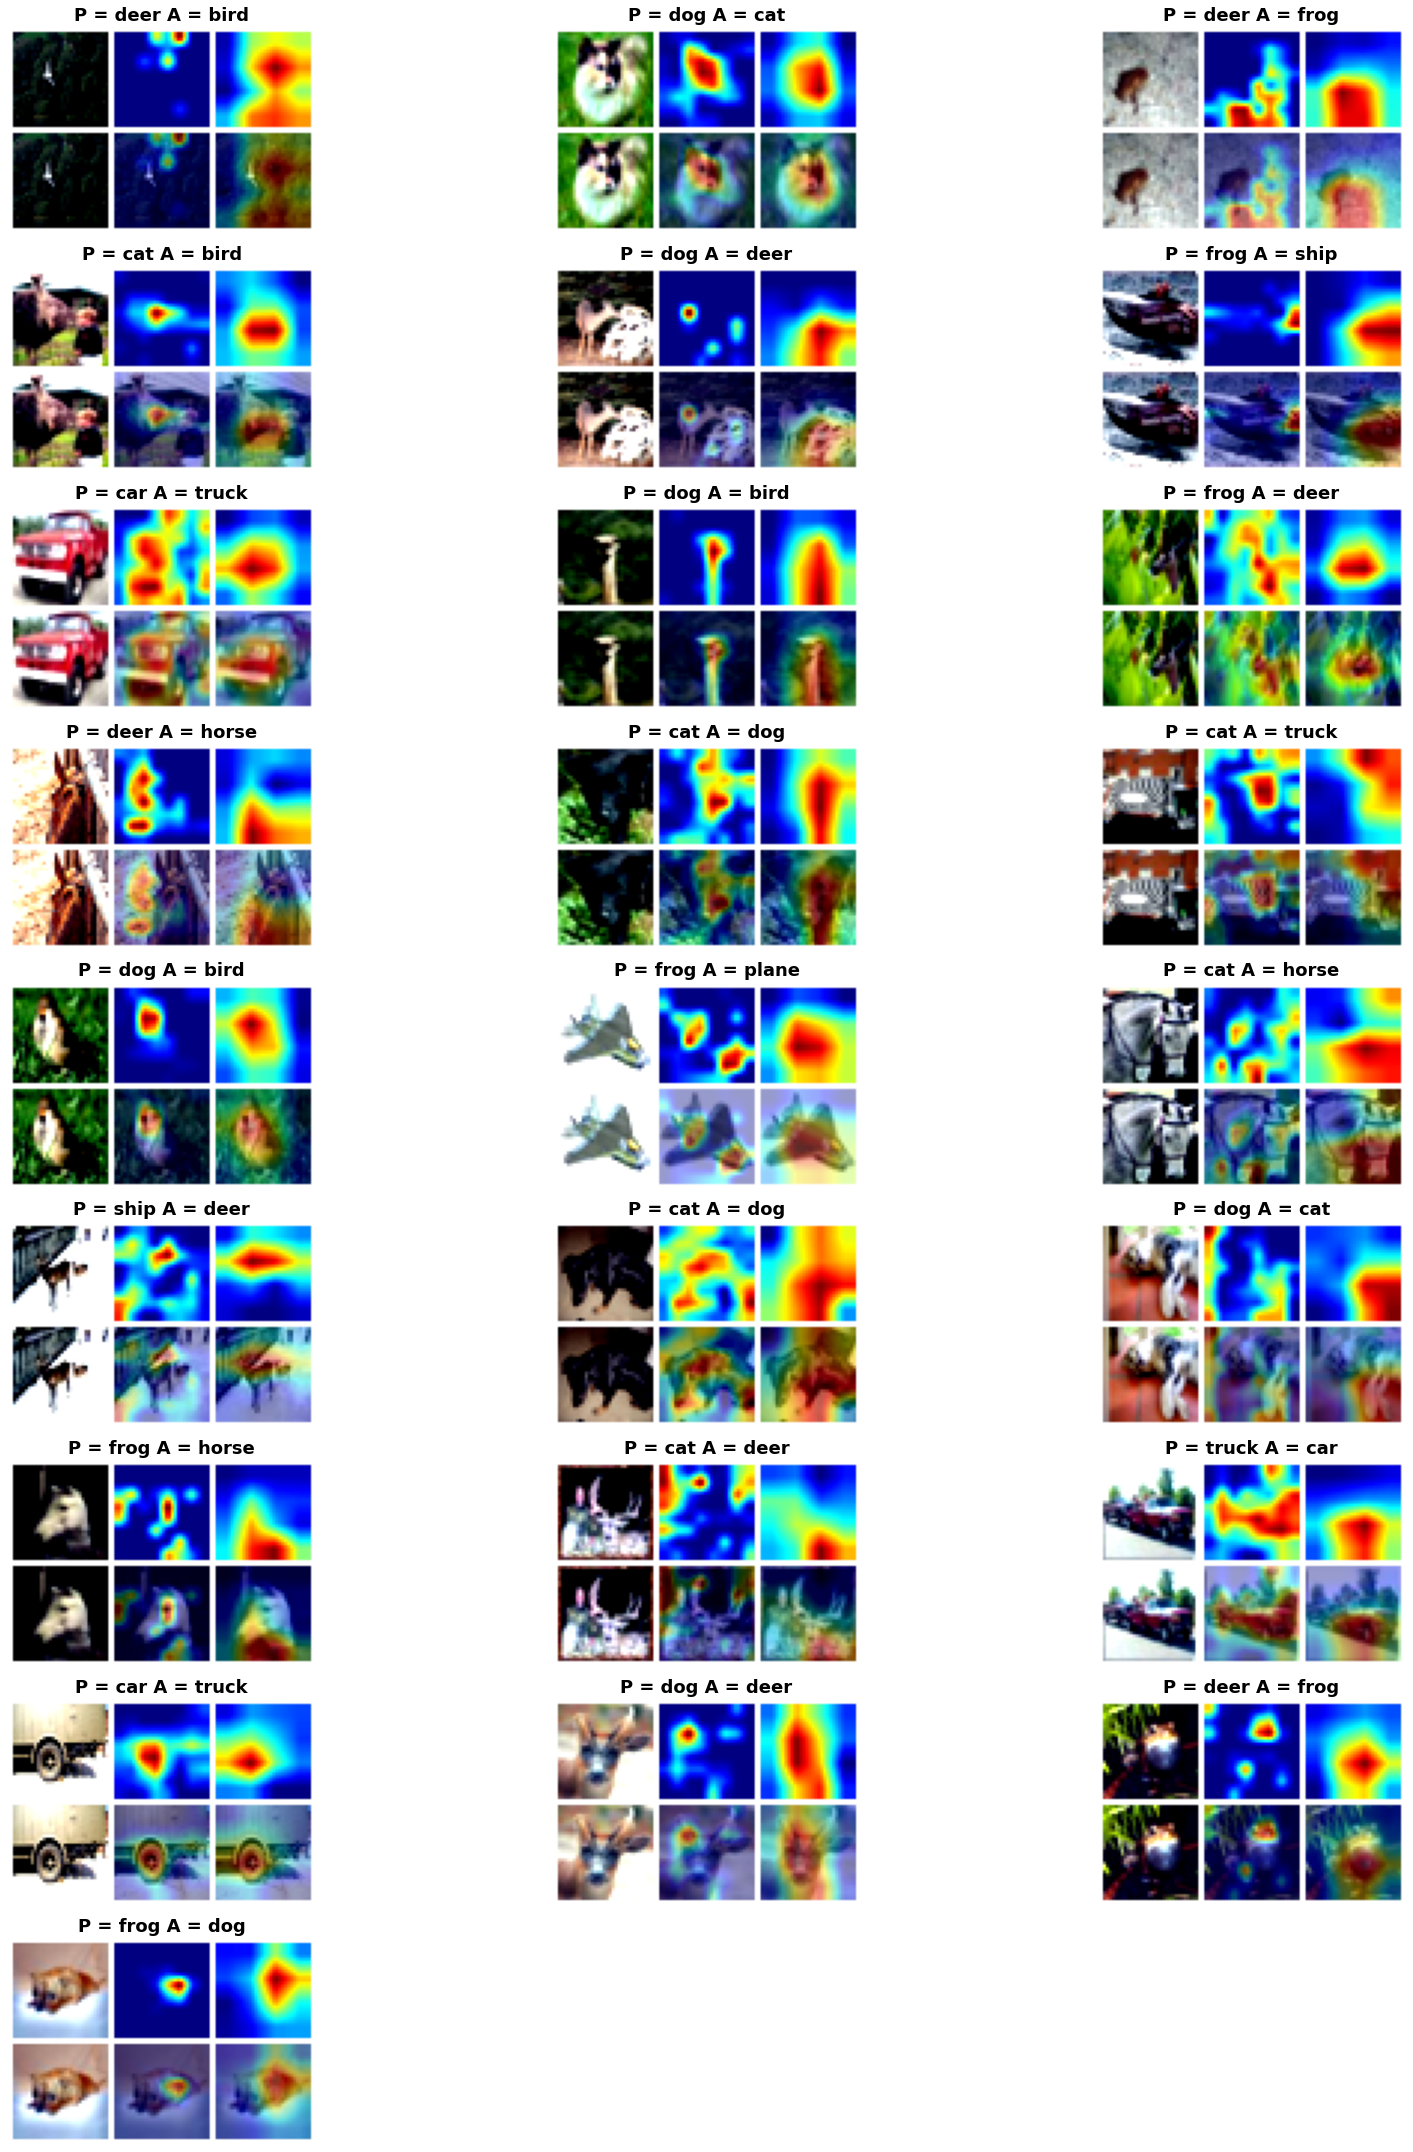

In [15]:
miscalssified_images = show_misclassified_images(model,device,test_loader,classes) # get he misclassfied Images
layers = [model.layer3,model.layer4]  # layers that we want to see in Gradcam.
GradCamView(miscalssified_images,model,classes,layers) # call Gradcam class.